# `pyGIMLi(emg3d)`

Super simple plus all possible inv-crimes (same mesh, some solver, ...).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import pygimli as pg

%run ../data/sampledata
    
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

## Load Simulation (incl. Survey, Models, Data)

In [3]:
sim, model = load_data("../data/Block-1src-130rec-1freq")
model_init = sim.model.copy()

sim.tol_gradient = 1e-2 # Reduce further

Data loaded from «/home/dtr/Codes/devInv/data/Block-1src-130rec-1freq.h5»
[emg3d v1.8.4.dev11+g36578d6 (format 1.0) on 2024-09-02T15:22:01.835714].


## Define regions, instantiate Kernel and Inversion

In [4]:
# Create region markers (as many different regions as you like)
markers = np.zeros(sim.model.shape, dtype=int)
#markers[:, :, grid.cell_centers_z > -500] = 1     # top two layers and bottom two layers
markers[model.property_x < 0.1] = 1            # Only target is free
#markers = np.zeros(sim.model.shape, dtype=int)
#markers[1:-1, :, :][:, 1:-1, :][:, :, 1:-2] = 1
#markers[1:-1, :, :][:, 1:-1, :][:, :, 1:-3] = 1
#markers[1:-1, :, :][:, 1:-1, :][:, :, -3:-1] = 2
#markers[1:-1, :, :][:, 1:-1, :][:, :, -2] = 2
#markers[1:-1, :, :][:, 1:-1, :][:, :, -3] = 3

# Instantiate the emg3d-kernel for pyGIMLi
fop = emg3d.inversion.pygimli.Kernel(simulation=sim, markers=markers, pgthreads=1)

# Instantiate the inversion and set some inversion parameters
INV = emg3d.inversion.pygimli.Inversion(fop=fop)
INV.inv.setCGLSTolerance(10)  # is _absolute_, not _relative_
INV.inv.setMaxCGLSIter(30)
#INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)

# Set the regions.
# Any number of regions is possible; alse `fix=True`, `single=True`, and `background=True`.
# Two different ways of the same: INV.setRegularization; INV.fop.setRegionProperties
INV.fop.setRegionProperties(1, #single=True,
                            limits=(0.0001, 2), startModel=1)                  # Target
INV.fop.setRegionProperties(0, background=True)                                   # Background
#INV.fop.setRegionProperties(2, fix=True, startModel=1)                           # Background
#INV.fop.setRegionProperties(3, single=True, limits=(0.1, 10.0), startModel=1.0)  # Background

# Constrain types (cType)
# 0 only damping (minimum length; only useful with good starting model and isReference=True in INV)
# 1 1st deriv - smoothing
# 2 2nd deriv
# 10, 20 - mixed form

# Depth weighting
# https://www.pygimli.org/_examples_auto/4_gravimetry_magnetics/plot_08_inv-magnetics-3d.html#depth-weighting

## Run inversion

In [5]:
INV.stopAtChi1 = False
INV.run(
    #maxIter=2, # just to test
    lam=1,  # btw 1-100
    #verbose=True,
    #debug=True,
    #startModel=model.property_x.ravel('F'),
    #isReference=True,
)

02/09/24 - 16:33:57 - pyGIMLi - INFO - :: pyGIMLi(emg3d) START ::
02/09/24 - 16:33:57 - pyGIMLi - INFO - Created startmodel from region infos: 6 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
02/09/24 - 16:34:00 - pyGIMLi - INFO - =======================================================================
                                        it        χ²   F(m)       λ         ϕᵈ         ϕᵐ   ϕ=ϕᵈ+λϕᵐ   Δϕ (%)
                                       -----------------------------------------------------------------------
02/09/24 - 16:34:00 - pyGIMLi - INFO -   0      17.4      1     1.0     4524.1        0.0     4524.1     0.00
02/09/24 - 16:34:19 - pyGIMLi - INFO -   1       0.7     12     1.0      182.9       13.4      196.3    95.66
02/09/24 - 16:34:29 - pyGIMLi - INFO -   2       0.3      6     1.0       85.2        4.7       89.9    54.19
02/09/24 - 16:34:38 - pyGIMLi - INFO -   3       0.3      6     1.0       70.3        0.1       70.4    21.66
02/09/24 - 16:34:48 - pyGIMLi - INFO -   4       0.3

# Plots

Depth slice: -750.0 m


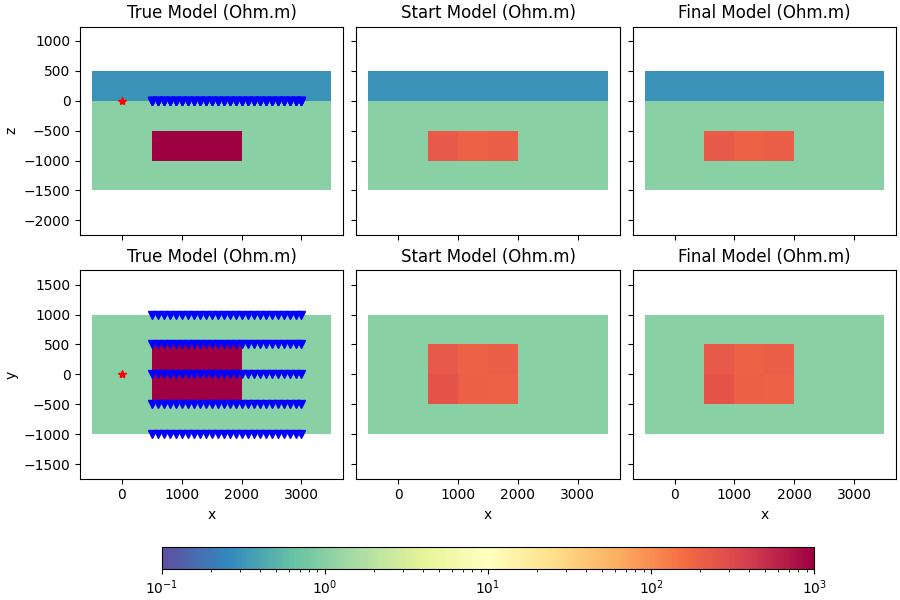

In [6]:
plot_models(sim, sim.model, model)

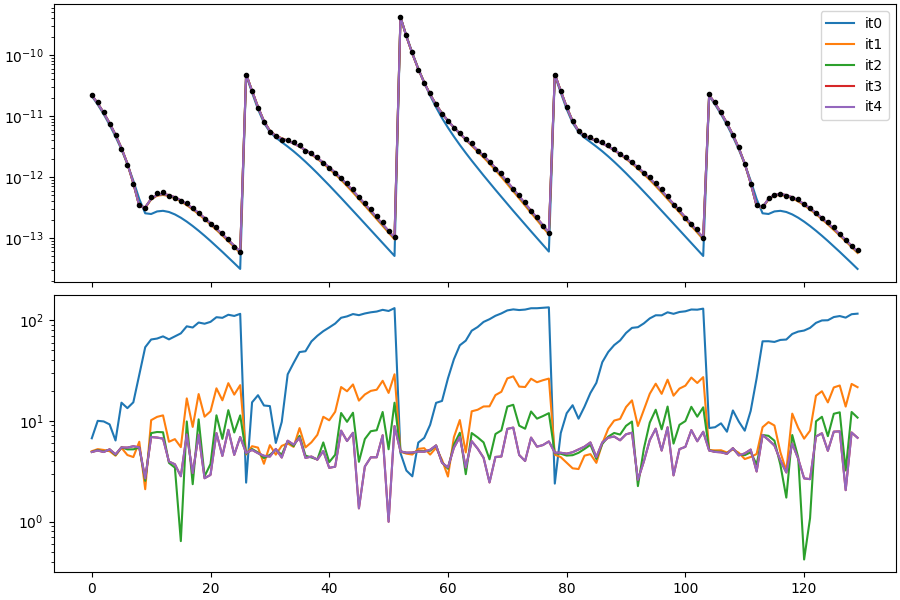

In [7]:
plot_responses(sim)

In [8]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Mon Sep 02 16:34:49 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.59.1
             emg3d : 1.8.4.dev6+gd2f88de
           empymod : 2.3.1
            xarray : 2024.6.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.1
              tqdm : 4.66.4
           IPython : 8.26.0
           pygimli : 1.5.2
            pgcore : 1.5.0
--------------------------------------------------------------------------------